In [3]:
import jax
import flax.linen as nn
import jax.numpy as jnp
import matplotlib.pyplot as plt

In [2]:
%config InlineBackend.figure_format = "retina"

## Idea 1:
1. Forma funcional que tiene la volatilidad en función del tiempo*
- Add fourier feature transformation

## An interpolation exercise

In [35]:
key = jax.random.PRNGKey(314)
key_x, key_y, key_iparams = jax.random.split(key, 3)

In [36]:
def f(x):
    return 0.4 + 0.1 * x - 1.2 + jnp.sin(x)

In [133]:
n_samples = 200
x = jax.random.uniform(key_x, (n_samples,), minval=-5, maxval=5)
# x = jnp.linspace(-5, 5, n_samples)
errs = jax.random.normal(key_y, (n_samples,)) * 0.4
y = f(x) + errs

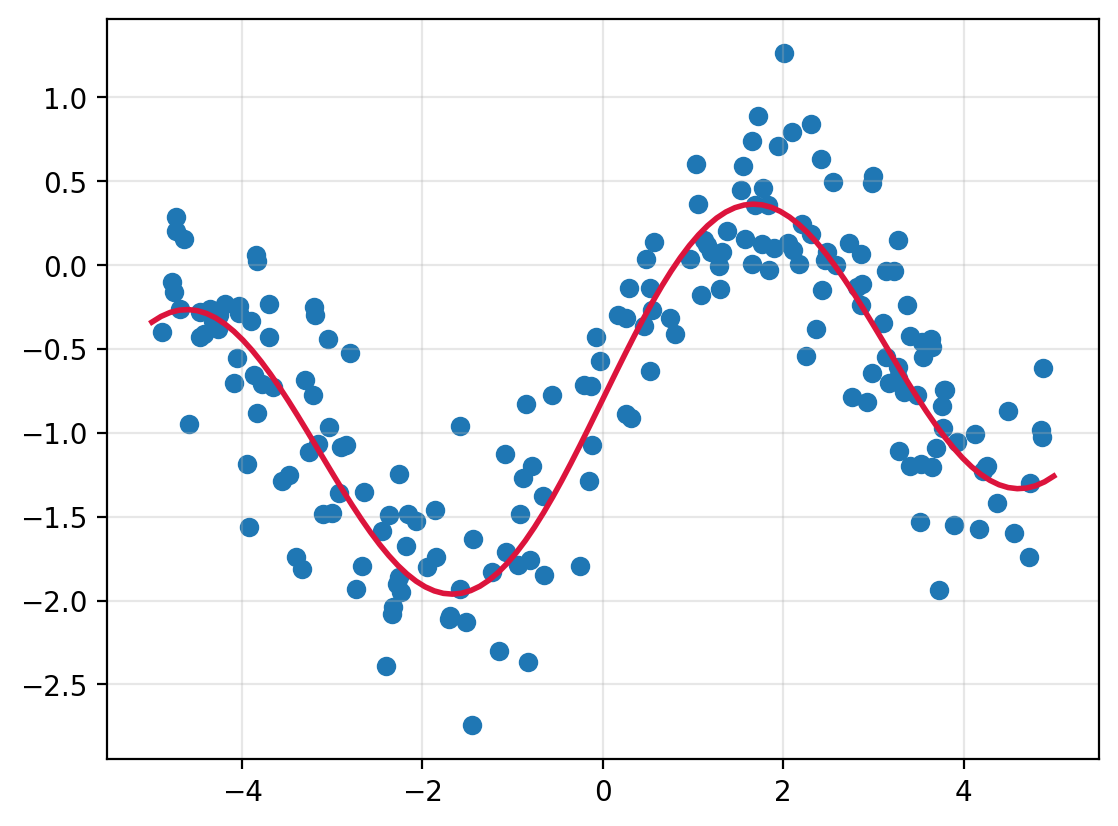

In [134]:
xrange = jnp.linspace(-5, 5, 100)
plt.plot(xrange, f(xrange), c="crimson", linewidth=2)
plt.scatter(x, y)
plt.grid(alpha=0.3)

In [135]:
import optax
from flax.training.train_state import TrainState

In [144]:
class MLP(nn.Module):
    @nn.compact
    def __call__(self, x):
        x = nn.Dense(10)(x)
        x = nn.relu(x)
        x = nn.Dense(10)(x)
        x = nn.relu(x)
        x = nn.Dense(10)(x)
        x = nn.relu(x)
        x = nn.Dense(1)(x)
        return x

In [145]:
model = MLP()
params_init = model.init(key_iparams, x[:, None])

In [146]:
def lossfn(params):
    yhat = model.apply(params, x[:, None]).ravel()
    return jnp.power(y - yhat, 2).mean()

In [147]:
vgloss = jax.value_and_grad(lossfn)

In [156]:
state = TrainState.create(
    apply_fn=model.apply,
    params=params_init,
    tx=optax.adam(1e-3)
)

In [157]:
from tqdm import tqdm

In [158]:
losses = []
for e in tqdm(range(300)):
    loss, grads = vgloss(state.params)
    state = state.apply_gradients(grads=grads)
    losses.append(loss.item())

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [00:19<00:00, 15.64it/s]


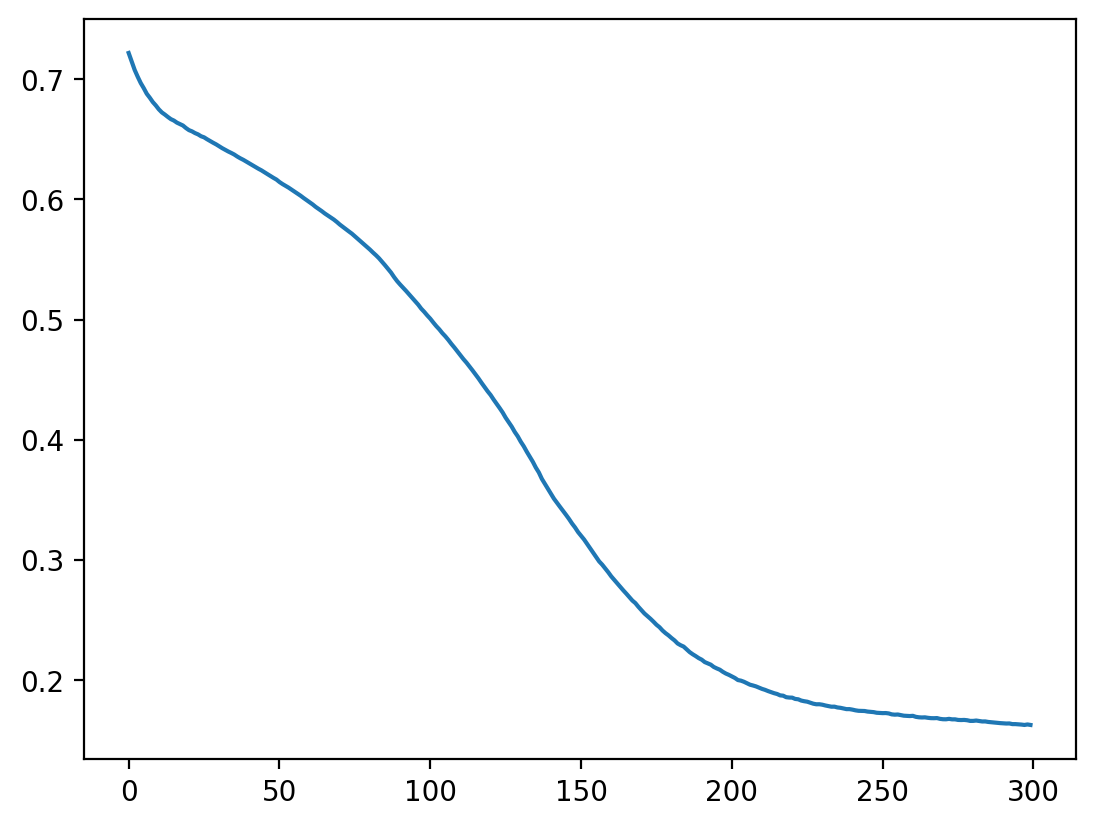

In [159]:
plt.plot(losses)

In [161]:
yeval = model.apply(state.params, xrange[:, None]).ravel()

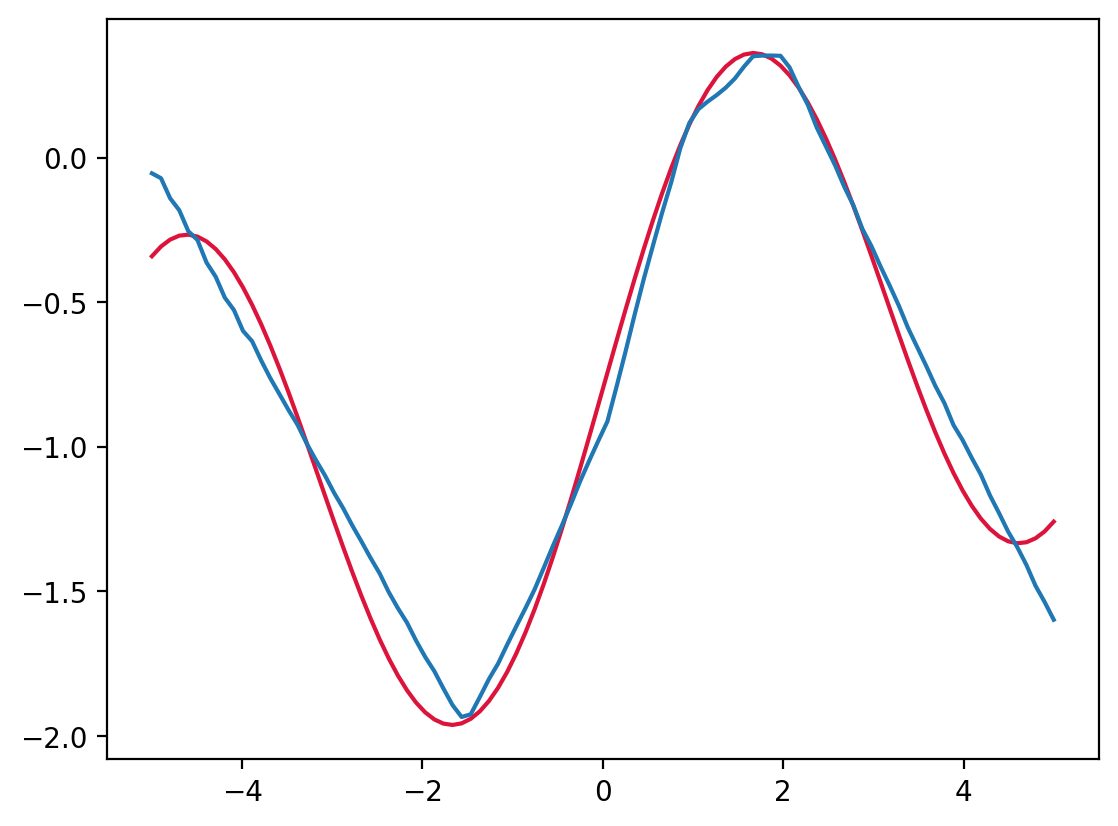

In [162]:
plt.plot(xrange, f(xrange), c="crimson")
plt.plot(xrange, yeval)